In [115]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import scipy 
import csv
import io as io
import os as os

colors = ['blue', 'green', 'red', 'cyan', 'yellow', 'purple', 'orange']

In [187]:
experimentDir = "finalData/"

allData = {}

for solverName in os.listdir(experimentDir):
    allData[solverName] = {}
    dimensions = os.listdir(experimentDir + "/" + solverName)
    for dimensionDir in sorted(dimensions):
        dimension = int(dimensionDir[2:])
        exData = allData[solverName][dimension] = {}
        exData["runs"] = []
        runDir = experimentDir+"/"+solverName+"/"+dimensionDir
        for runData in os.listdir(runDir):
            runDataPath = runDir + "/" + runData
            if runData.startswith("run"):
                table = pd.read_csv(runDataPath, names=["runtime","cntProbe","merit"], header=None)
                exData["runs"].append(table) 
            else:
                table = pd.read_csv(runDataPath, names=["timeout","hitsN","hitRatio","avgT"], header=None)
                exData["summary"] = table

In [22]:
concreteRun = allData["tabu"][45]
sampleRun = concreteRun["runs"][0]
display(concreteRun["summary"])

,timeout,hitsN,hitRatio,avgT
0,90000,36,0.72,33862


0.8845891533520475
0.009103187168432595
0.9324375300911278


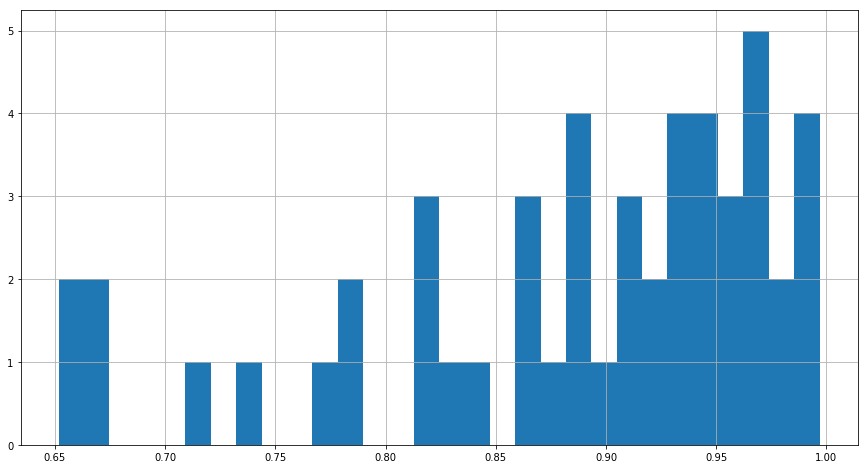

In [147]:
# Sample correlation

concreteRun = allData["tabu"][35]
corrTable = pd.DataFrame()
for table in concreteRun["runs"]:
    corrVal = table["runtime"].corr(sampleRun["cntProbe"])
    corrTable = corrTable.append({"corr": corrVal}, ignore_index = True)

print(corrTable["corr"].mean())
print(corrTable["corr"].var())
print(corrTable["corr"].quantile(q=0.6))
corrTable["corr"].hist(bins=30)

In [148]:
# Average correlation over one run

corrTable = pd.DataFrame()
for n, data in allData["tabu"].items():
    for table in data["runs"]:
        corrVal = table["runtime"].corr(sampleRun["cntProbe"])
        corrTable = corrTable.append({n: corrVal}, ignore_index = True)

resTable = pd.DataFrame()
for n in corrTable:   
    resTable = resTable.append({ "n": n
                      , "mean": corrTable[n].mean()
                      , "var": corrTable[n].var()
                      , "q05": corrTable[n].quantile(q=0.5)
                      , "q075": corrTable[n].quantile(q=0.75)
                      , "q095": corrTable[n].quantile(q=0.95)}, ignore_index = True)

aggTable = resTable.drop(columns=["n"]).agg(["mean"])
display(aggTable)

,mean,q05,q075,q095,var
mean,0.887008,0.90511,0.954519,0.984813,0.00739


In [301]:
#Optimal values
optimalValues = {3: 4.5,4: 4,5: 6.25,6: 2.57143,7: 8.16667,8: 4,9: 3.375,10: 3.84615,11: 12.1,12: 7.2,13: 14.0833,14: 5.15789,15: 7.5,16: 5.33333,17: 4.51562,18: 6.48,19: 6.22414,20: 7.69231,21: 8.48077,22: 6.20513,23: 5.62766,24: 8,25: 8.68056,26: 7.51111,27: 9.85135,28: 7.84,29: 6.78226,30: 7.62712,31: 7.17164,32: 8,33: 8.50781,34: 8.89231,35: 8.39041,36: 7.90244,37: 7.9593,38: 8.29885,39: 7.68182,40: 7.40741,41: 7.78241,42: 8.73267,43: 8.48165,44: 7.93443,45: 8.58051,46: 8.07634,47: 8.18148,48: 8.22857,49: 8.82721,50: 8.16993,51: 8.5,52: 8.14458,53: 8.26176,54: 8.33143,55: 8.84503,56: 8.16667,57: 8.64096,58: 8.53807,59: 8.49024}

In [263]:
runtimeModels = {}

In [270]:
allSolvers = ["tabu","ma","sals","sa"]

{'mean': array([2.04642916e-04, 2.97183439e-01]), 'q50': array([0.00151742, 0.26469245]), 'q75': array([0.00151216, 0.26919219]), 'q95': array([0.00415808, 0.24539886])}


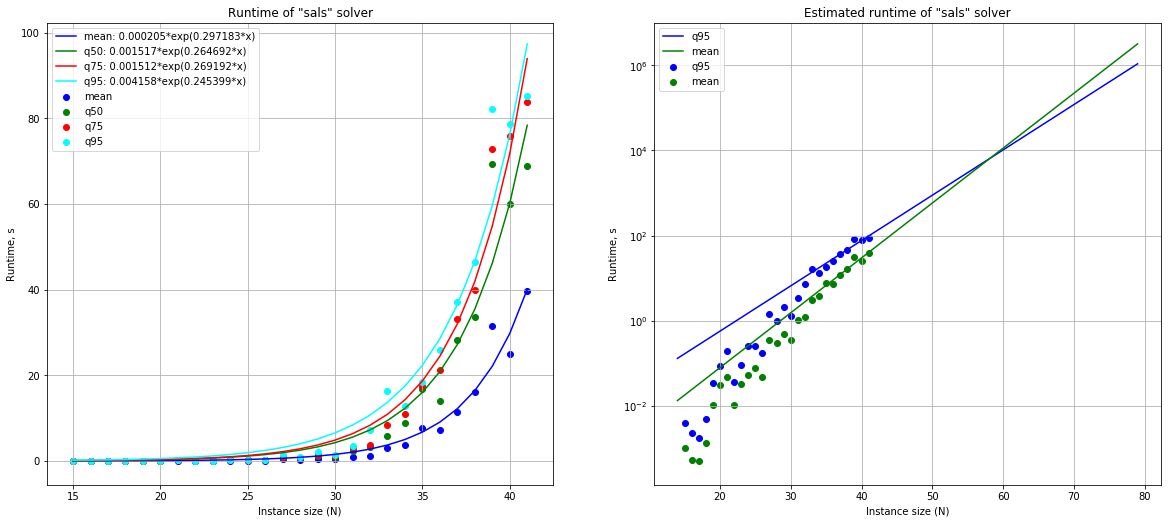

In [408]:
solver="sals"

sMaxN = { "sa": 29
        , "tabu": 44
        , "ma": 42
        , "sals": 41 }

# Exp fitting params
# TODO tune up?
p0param = { "tabu": (15, 0.8)
          , "sa": (15,0.8)
          , "ma": (15, 0.8)
          , "sals": (5,0.87)}

maxN = sMaxN[solver]

runtimesTable = pd.DataFrame()
for n, data in allData[solver].items():
    if n > maxN: continue;
    runtimes = []
    for table in data["runs"]:
        runtimes.append(table["runtime"].iloc[-1]/1000000)
    curRow = pd.DataFrame({n:runtimes})
    runtimesTable = runtimesTable.join(curRow, how="outer")

#display(runtimesTable)
runtimesTable[maxN].hist(bins=15)

tlTable = pd.DataFrame()
for n in runtimesTable:
    tlTable = tlTable.append({"n":n
                              , "mean": (runtimesTable[n].mean())
                              , "q50": (runtimesTable[n].quantile(q=0.90))
                              , "q75": (runtimesTable[n].quantile(q=0.95))
                              , "q95": (runtimesTable[n].quantile(q=0.99))
                             }, ignore_index=True)

#print(tlTable.loc[tlTable["n"] == maxN])
    

plt.rcParams["figure.figsize"] = (16,7)
    
plt.tight_layout()
plt.subplot(1,2,1)
approxs = {}
runtimeModels[solver + "_formula"] = {}
for qparam, col in zip(["mean","q50","q75","q95"],colors):
    plt.scatter(tlTable["n"], tlTable[qparam], color=col, label=qparam)
    (appr,_) = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t), tlTable["n"]
                                        , tlTable[qparam], p0=p0param[solver])
    approxs[qparam] = appr
    ns = range(15,maxN+1)
    formula = "{:.6f}".format(appr[0]) + "*exp(" + "{:.6f}".format(appr[1]) + "*x)"
    runtimeModels[solver + "_formula"][qparam] = formula
    plt.plot(ns,appr[0]*np.exp(appr[1]*ns), label=(qparam + ": " + formula), color=col)
    
print(approxs)

runtimeModels[solver] = approxs
 

plt.grid(True)
plt.legend(loc='upper left') 
plt.xlabel("Instance size (N)")
plt.ylabel("Runtime, s")
plt.title('Runtime of "' + solver + '" solver')

plt.subplot(1,2,2)
plt.yscale('log')
xrange = range(14,80)
for k, col in zip(["q95","mean"], colors):
    plt.scatter(tlTable["n"], tlTable[k], color=col)
    v = approxs[k]
    plt.plot(xrange,v[0]*np.exp(v[1]*xrange), label=(k), color=col)


plt.grid(True)
plt.xlabel("Instance size (N)")
plt.ylabel("Runtime, s")
plt.title('Estimated runtime of "' + solver + '" solver')
plt.savefig("pics/"+solver+"/runtime.pdf", type="pdf")
plt.legend(loc='upper left')

plt.show()

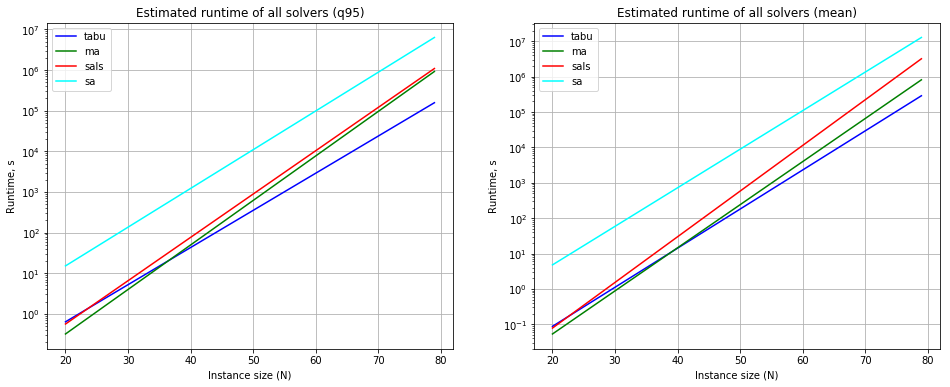

In [391]:
plt.rcParams["figure.figsize"] = (16,6)
plt.tight_layout()

xrange = range(20,80)

for q,i in zip(["q95","mean"],[1,2]):
    plt.subplot(1,2,i)
    plt.yscale('log')

    for solver,col in zip(allSolvers,colors):
        model = runtimeModels[solver]
        v = model[q]
        plt.plot(xrange,v[0]*np.exp(v[1]*xrange), label=solver,  color=col)

    plt.grid(True)
    plt.xlabel("Instance size (N)")
    plt.ylabel("Runtime, s")
    plt.title('Estimated runtime of all solvers ('+q+')')
    plt.legend(loc='upper left')


plt.savefig("pics/runtime_global.pdf", type="pdf")
plt.show()

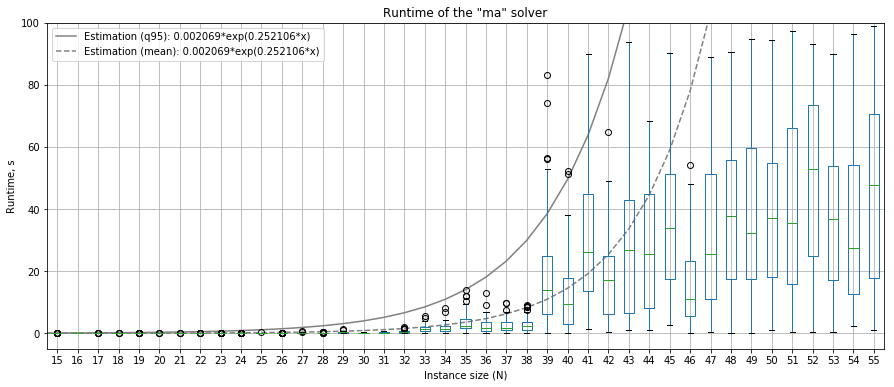

In [417]:
solver = "ma"

runtimesOverviewTable = pd.DataFrame()
for n, data in allData[solver].items():
    runtimes = []
    for table in data["runs"]:
        runtimes.append(table["runtime"].iloc[-1]/1000000)
    curRow = pd.DataFrame({n:runtimes})
    runtimesOverviewTable = runtimesOverviewTable.join(curRow, how="outer")

plt.xlabel("Instance size (N)")
plt.ylabel("Runtime, s")
plt.title('Runtime of the "' + solver + '" solver')
plt.rcParams["figure.figsize"] = (15,6)
xrange = range(0,55)
for q,l in zip(["q95","mean"],["-","--"]):
    v = runtimeModels[solver][q]
    plt.plot(list(map(lambda x: x-14, xrange)),v[0]*np.exp(v[1]*xrange),
         label=("Estimation ("+q+"): " + runtimeModels[solver+"_formula"]["q95"]), linestyle=l, color='grey')
plt.ylim(top=100,bottom=(-5))
plt.legend(loc='upper left')
runtimesOverviewTable.boxplot()
plt.savefig("pics/"+solver+"/runtime_boxes.pdf", type="pdf")
plt.show()

In [377]:
# Transform the table to get the relative distance of runs
for solver in allSolvers:
    for n, data in allData[solver].items():
        for i in range(len(data["runs"])):
            curTable = data["runs"][i]
            allData[solver][n]["runs"][i]['meritRel'] = curTable.apply((lambda row: (1 - row['merit']/optimalValues[n])*100), axis=1)

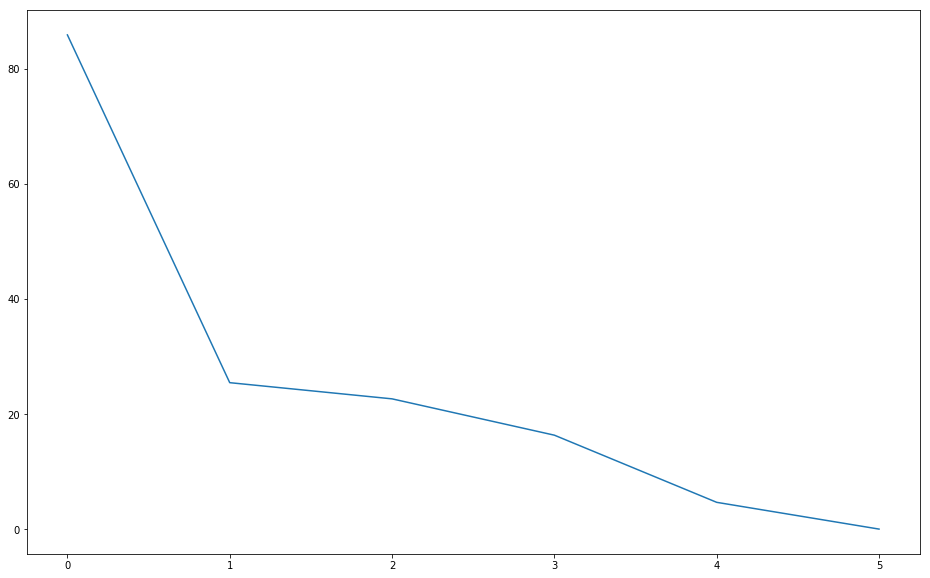

In [378]:
allData["ma"][36]["runs"][5]["meritRel"].plot()

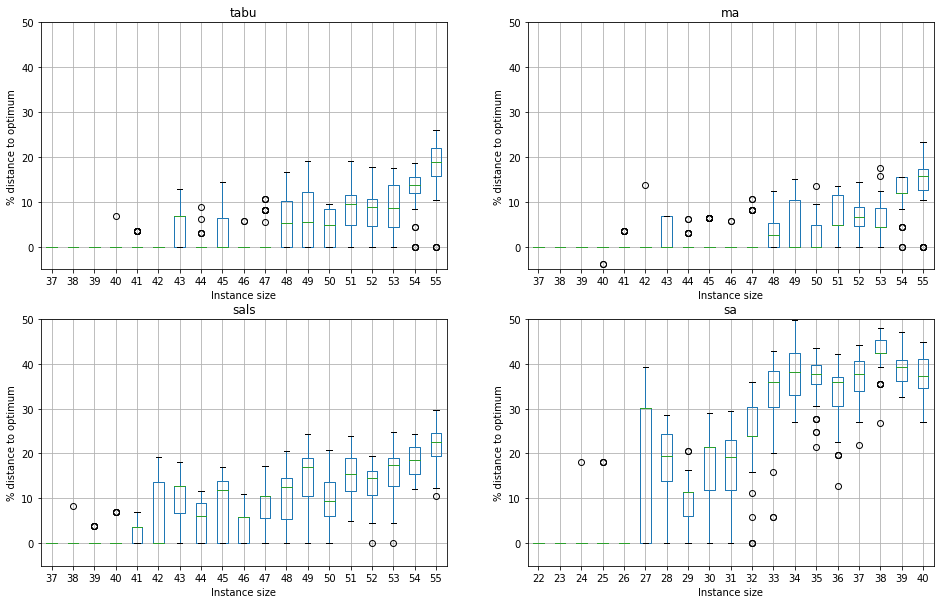

In [385]:
# Box plots for relative end distances
nstart = { "sa": 22
        , "tabu": 37
        , "ma": 37
        , "sals": 37 }
plt.rcParams["figure.figsize"] = (16,10)
distancesOverviewTable = {}
for solver, i in zip(allSolvers,range(1,5)):
    distancesOverviewTable[solver] = pd.DataFrame()
    for n, data in allData[solver].items():
        if n < nstart[solver]: continue
        distances = []
        for table in data["runs"]:
            distances.append(table["meritRel"].iloc[-1])
        curRow = pd.DataFrame({n:distances})
        distancesOverviewTable[solver] = distancesOverviewTable[solver].join(curRow, how="outer")
    plt.subplot(2,2,i)
    plt.ylim(top=50,bottom=(-5))
    plt.xlabel("Instance size")
    plt.ylabel("% distance to optimum")
    plt.title(solver)
    distancesOverviewTable[solver].boxplot()

plt.savefig("pics/distance_boxes.pdf", type="pdf")